In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch
import numpy as np
from collections import deque, namedtuple

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


# Environment Declaration

In [ ]:
env_acrobot = gym.make('Acrobot-v1')
state_dim_acrobot = env_acrobot.observation_space.shape
action_dim_acrobot = env_acrobot.action_space.n

env_cartpole = gym.make('CartPole-v1')
state_dim_cartpole = env_cartpole.observation_space.shape
action_dim_cartpole = env_cartpole.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
print(state_dim_acrobot)
print(state_dim_cartpole)
print(action_dim_acrobot)
print(action_dim_cartpole)

(6,)
(4,)
3
2


# Q-Network:
The neural network used as a function approximator is defined below

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 0.0001               # learning rate
UPDATE_EVERY = 20       # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class QNetwork_Dueling(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        super(QNetwork_Dueling, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)

        # Advantage layer
        self.fc_advantage = nn.Linear(fc2_units, action_size)

        # Value layer
        self.fc_value = nn.Linear(fc2_units, 1)

    def forward(self, state, update_type):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        # Advantage stream
        advantage = self.fc_advantage(x)

        # Value stream
        value = self.fc_value(x)

        if update_type == 'Type-1':
            # Type-1 update formula
            q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        elif update_type == 'Type-2':
            # Type-2 update formula
            max_advantage = torch.max(advantage, dim=1, keepdim=True)[0]
            q_values = value + (advantage - max_advantage)
        else:
            raise ValueError("Invalid update_type. Supported types: 'Type-1', 'Type-2'")

        return q_values


# Replay Buffer:

In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)


    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# DuelingDQNAgent

In [ ]:
class DuelingDQNAgent:
    def __init__(self, state_size, action_size, seed):


        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        # Set the seed for reproducibility
        torch.manual_seed(seed)
        self.qnetwork_local = QNetwork_Dueling(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork_Dueling(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)'''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done,update_type):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)


        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA,update_type)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
            #self.soft_update(self.qnetwork_local, self.qnetwork_target, 1e-3)

    def act(self, state, tau , update_type):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state,update_type)
        self.qnetwork_local.train()

        action_values = action_values.cpu().data.numpy()
        max_value = action_values.max()
        exp_values = np.exp((action_values - max_value) / tau)
        normalizer = np.sum(exp_values)
        prob = exp_values / normalizer
        prob=prob.squeeze()
        action = np.random.choice(np.arange(self.action_size), p=prob)
        return action

    def learn(self, experiences, gamma , update_type):

        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states,update_type).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states,update_type).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)


        self.optimizer.step()

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

# Here, we present the DQN algorithm code.

In [ ]:
''' Defining DQN Algorithm '''



def dqn(env,agent, env_name,update_type, n_episodes=150, max_t=1000, tau_start=1.0, tau_end=0.01, tau_decay=0.995 ):

    # to store the rewards of each episodes for plotting
    softmax_reward=[]



    ''' last 100 scores for checking if the avg is more than 195 '''
    scores_window = deque(maxlen=100)

    ''' initialize epsilon '''
    tau = tau_start

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, tau , update_type=update_type)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done,update_type)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)

        # storing reward of episode for plotting

        softmax_reward.append(score)

        ''' decrease epsilon '''
        tau = max(tau_end, tau_decay*tau)

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 50 == 0:
            print('\rEpisode {}\tFor {}\t {}\tAverage Score: {:.2f}'.format(i_episode,env_name,update_type, np.mean(scores_window)))



    # returning rewards for plotting

    return softmax_reward[:n_episodes]





# Moving average

In [ ]:
def moving_average(a):
    n=len(a)
    padded = np.concatenate([np.zeros(n-1), a])
    conv = np.convolve(padded, np.ones(n), 'valid')
    conv[:n] = conv[:n] / np.arange(1,n+1)
    conv[n:] = conv[n:] / n
    return conv

# DDQN for Cartpole-v1

Episode 50	For CartPole-v1	 Type-1	Average Score: 16.26
Episode 100	For CartPole-v1	 Type-1	Average Score: 23.97
Episode 150	For CartPole-v1	 Type-1	Average Score: 62.97
Episode 200	For CartPole-v1	 Type-1	Average Score: 112.43
Episode 250	For CartPole-v1	 Type-1	Average Score: 176.42
Episode 50	For CartPole-v1	 Type-2	Average Score: 21.26
Episode 100	For CartPole-v1	 Type-2	Average Score: 44.15
Episode 150	For CartPole-v1	 Type-2	Average Score: 113.91
Episode 200	For CartPole-v1	 Type-2	Average Score: 178.40
Episode 250	For CartPole-v1	 Type-2	Average Score: 167.88
Episode 50	For CartPole-v1	 Type-1	Average Score: 16.12
Episode 100	For CartPole-v1	 Type-1	Average Score: 18.10
Episode 150	For CartPole-v1	 Type-1	Average Score: 52.33
Episode 200	For CartPole-v1	 Type-1	Average Score: 112.88
Episode 250	For CartPole-v1	 Type-1	Average Score: 205.22
Episode 50	For CartPole-v1	 Type-2	Average Score: 20.24
Episode 100	For CartPole-v1	 Type-2	Average Score: 22.98
Episode 150	For CartPole-v1	

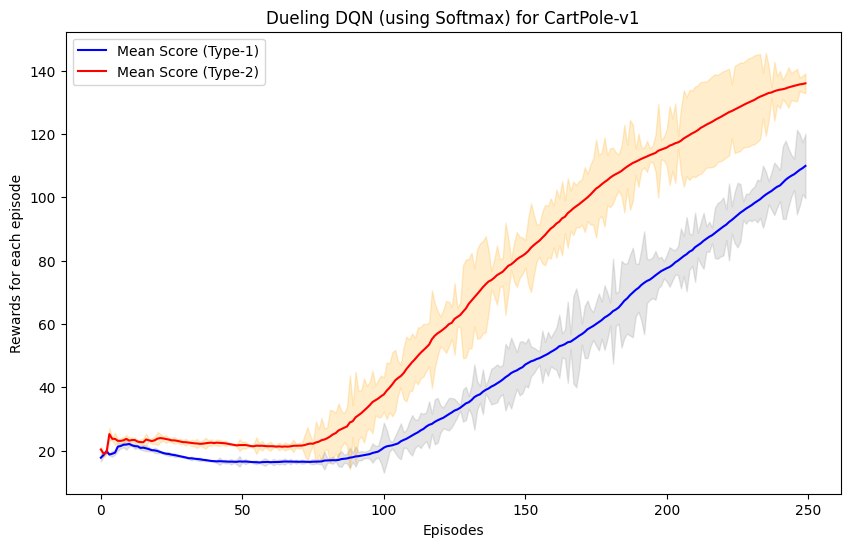

In [ ]:
env_cartpole = gym.make('CartPole-v1')


env_name = 'CartPole-v1'

n_seeds=5
n_episodes=250

state_dim_cartpole = env_cartpole.observation_space.shape[0]
action_dim_cartpole = env_cartpole.action_space.n

all_scores_type_1 = np.zeros((n_seeds,n_episodes))
all_scores_type_2 = np.zeros((n_seeds,n_episodes))



for seed in range(n_seeds):


    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env_cartpole.seed(seed)

    agent_1 = DuelingDQNAgent(state_dim_cartpole, action_dim_cartpole, seed=seed)


    # Update type 1
    update_type_1 = 'Type-1'
    scores_type_1 = dqn(env_cartpole, agent_1,env_name,update_type=update_type_1, n_episodes=n_episodes)
    all_scores_type_1[seed] = scores_type_1

    agent_2 = DuelingDQNAgent(state_dim_cartpole, action_dim_cartpole, seed=seed)


    # Update type 2
    update_type_2 = 'Type-2'
    scores_type_2 = dqn(env_cartpole, agent_2,env_name,update_type=update_type_2, n_episodes=n_episodes)
    all_scores_type_2[seed] = scores_type_2

    env_cartpole.close()



mean_scores_type_1 = np.mean(all_scores_type_1, axis=0)  # Calculate mean along episodes axis
std_scores_type_1 = np.std(all_scores_type_1, axis=0)    # Calculate standard deviation along episodes axis


mean_scores_type_2 = np.mean(all_scores_type_2, axis=0)  # Calculate mean along episodes axis
std_scores_type_2= np.std(all_scores_type_2, axis=0)    # Calculate standard deviation along episodes axis


# Moving average for update type 1 and type 2 for cartpole
mean_scores_1=moving_average(mean_scores_type_1)
mean_scores_2=moving_average(mean_scores_type_2)



episodes = np.arange(n_episodes)

plt.figure(figsize=(10, 6))
plt.plot(episodes, mean_scores_1, label=f'Mean Score ({update_type_1})', color='blue')
plt.fill_between(episodes, mean_scores_1 - 0.1*std_scores_type_1, mean_scores_1 + 0.1*std_scores_type_1, color='gray', alpha=0.2)

# Plot for update type 2
plt.plot(episodes, mean_scores_2, label=f'Mean Score ({update_type_2})', color='red')
plt.fill_between(episodes, mean_scores_2 - 0.1*std_scores_type_2, mean_scores_2 + 0.1*std_scores_type_2, color='orange', alpha=0.2)

plt.title(f'Dueling DQN (using Softmax) for {env_name}')
plt.xlabel('Episodes')
plt.ylabel('Rewards for each episode')
plt.legend()
plt.show()

# DDQN for Acrobot-v1

Episode 50	For Acrobot-v1	 Type-1	Average Score: -183.86
Episode 100	For Acrobot-v1	 Type-1	Average Score: -172.90
Episode 150	For Acrobot-v1	 Type-1	Average Score: -149.67
Episode 200	For Acrobot-v1	 Type-1	Average Score: -123.39
Episode 250	For Acrobot-v1	 Type-1	Average Score: -106.40
Episode 50	For Acrobot-v1	 Type-2	Average Score: -280.44
Episode 100	For Acrobot-v1	 Type-2	Average Score: -210.87
Episode 150	For Acrobot-v1	 Type-2	Average Score: -128.83
Episode 200	For Acrobot-v1	 Type-2	Average Score: -111.23
Episode 250	For Acrobot-v1	 Type-2	Average Score: -105.41
Episode 50	For Acrobot-v1	 Type-1	Average Score: -218.36
Episode 100	For Acrobot-v1	 Type-1	Average Score: -179.26
Episode 150	For Acrobot-v1	 Type-1	Average Score: -131.04
Episode 200	For Acrobot-v1	 Type-1	Average Score: -120.13
Episode 250	For Acrobot-v1	 Type-1	Average Score: -108.71
Episode 50	For Acrobot-v1	 Type-2	Average Score: -246.40
Episode 100	For Acrobot-v1	 Type-2	Average Score: -207.53
Episode 150	For Ac

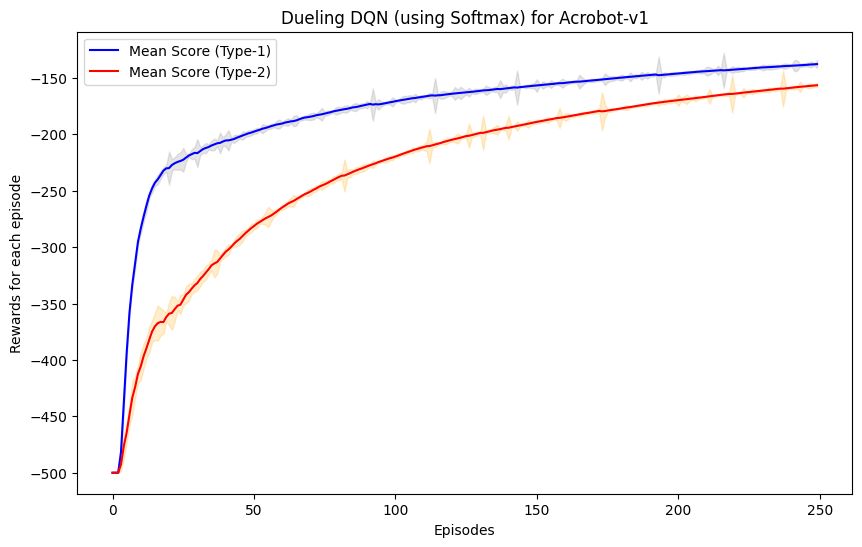

In [ ]:
env_acrobot = gym.make('Acrobot-v1')


env_name = 'Acrobot-v1'

n_seeds=5
n_episodes=250

state_dim_acrobot = env_acrobot.observation_space.shape[0]
action_dim_acrobot = env_acrobot.action_space.n

all_scores_type_1 = np.zeros((n_seeds,n_episodes))
all_scores_type_2 = np.zeros((n_seeds,n_episodes))



for seed in range(n_seeds):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env_acrobot.seed(seed)


    agent_1 = DuelingDQNAgent(state_dim_acrobot, action_dim_acrobot, seed=seed)

    # Update type 1
    update_type_1 = 'Type-1'
    scores_type_1 = dqn(env_acrobot, agent_1,env_name,update_type=update_type_1, n_episodes=n_episodes)
    all_scores_type_1[seed] = scores_type_1

    agent_2 = DuelingDQNAgent(state_dim_acrobot, action_dim_acrobot, seed=seed)


    # Update type 2
    update_type_2 = 'Type-2'
    scores_type_2 = dqn(env_acrobot, agent_2,env_name,update_type=update_type_2, n_episodes=n_episodes)
    all_scores_type_2[seed] = scores_type_2
    env_acrobot.close()



mean_scores_type_1 = np.mean(all_scores_type_1, axis=0)  # Calculate mean along episodes axis
std_scores_type_1 = np.std(all_scores_type_1, axis=0)    # Calculate standard deviation along episodes axis


mean_scores_type_2 = np.mean(all_scores_type_2, axis=0)  # Calculate mean along episodes axis
std_scores_type_2= np.std(all_scores_type_2, axis=0)    # Calculate standard deviation along episodes axis


# Moving average for update type 1 and type 2 for cartpole
mean_scores_1=moving_average(mean_scores_type_1)
mean_scores_2=moving_average(mean_scores_type_2)




episodes = np.arange(n_episodes)
# Plot for update type 1
plt.figure(figsize=(10, 6))
plt.plot(episodes, mean_scores_1, label=f'Mean Score ({update_type_1})', color='blue')
plt.fill_between(episodes, mean_scores_1 - 0.1*std_scores_type_1, mean_scores_1 + 0.1*std_scores_type_1, color='gray', alpha=0.2)

# Plot for update type 2
plt.plot(episodes, mean_scores_2, label=f'Mean Score ({update_type_2})', color='red')
plt.fill_between(episodes, mean_scores_2 - 0.1*std_scores_type_2, mean_scores_2 + 0.1*std_scores_type_2, color='orange', alpha=0.2)

plt.title(f'Dueling DQN (using Softmax) for {env_name}')
plt.xlabel('Episodes')
plt.ylabel('Rewards for each episode')
plt.legend()
plt.show()


# MONTE CARLO REINFORCE ALGORITHM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import time

class MonteCarloREINFORCE:
    def __init__(self, env, policy_net, gamma, with_baseline=False):
        self.env = env
        self.policy_net = policy_net
        self.gamma = gamma
        self.reset_history()
        self.return_history = [0]
        self.with_baseline = with_baseline

    def reset_history(self):
        self.log_probs = []
        self.rewards = [0]



    def select_action(self, state,return_log_prob=False):
        #-------------------------------------------
        # Convert state to Tensor (from np.array)
        #-------------------------------------------
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
            state = state.unsqueeze(0)

        # Send state to device (CPU/GPU)
        state = state.to(device)

        #-------------------------------------------
        # Use policy network to select action
        #-------------------------------------------
        self.policy_net=self.policy_net.to(device)
        dist_params = self.policy_net(state)
        prob_dist = torch.distributions.Categorical(logits=dist_params)
        action = prob_dist.sample()

        #--------------------------------------------
        # Return action and (optinally) log_prob
        #--------------------------------------------
        if return_log_prob:
            log_prob = prob_dist.log_prob(action) #.unsqueeze(-1)
            return action.item(), log_prob
        else:
            return action.item()

    def generate_episode(self, max_steps=None):
        if max_steps is None:
            max_steps = float('inf')

        t = 0
        state = self.env.reset()
        self.reset_history()

        while t < max_steps:
            t += 1
            action, log_prob = self.select_action(state, return_log_prob=True)
            next_state, reward, done, _  = self.env.step(action)
            self.rewards.append(reward)
            self.log_probs.append(log_prob)
            state = next_state
            if done:
                break
            state = next_state

    def train(self, episodes, lr, max_steps=None, updates=None,env_name=None):
        optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        baseline = 0.0
        score=[]
        self.return_history=[0]
        state = self.env.reset()
        for n in range(episodes):
            #--------------------------------------------
            # Create episode and calculate returns
            #--------------------------------------------
            self.generate_episode(max_steps=max_steps)
            T = len(self.rewards)
            returns = np.zeros(T)
            Gt = 0
            for t in reversed(range(T)):
                Gt = self.rewards[t] + self.gamma * Gt
                #Gt = self.gamma**(T - t - 1) + Gt
                returns[t] = Gt


            #--------------------------------------------
            # Calculate Advantage Estimate
            #--------------------------------------------
            ret_tensor = torch.FloatTensor(returns).unsqueeze(1).to(device)
            if self.with_baseline:
                # Compute the advantage estimate (Gt - V(St; Φ))
                baseline_tensor = torch.FloatTensor([baseline]).to(device)
                adv_tensor = ret_tensor - baseline_tensor

                # Update the baseline
                baseline += lr * (ret_tensor.mean() - baseline)

            else:
                # Without baseline, set the advantage estimate equal to the returns
                adv_tensor = ret_tensor.clone()

            #--------------------------------------------
            # Calculate Loss
            #--------------------------------------------
            adv_tensor = adv_tensor.to(device)
            log_probs = torch.cat(self.log_probs)
            loss = -torch.sum(log_probs * adv_tensor)

            #--------------------------------------------
            # Gradient Descent
            #--------------------------------------------
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            self.return_history.append(returns[0])
            score.append(returns[0])
            ret_100 = np.mean(self.return_history[-100:])

            #--------------------------------------------
            # Output
            #--------------------------------------------

            if updates is not None:
                if (n + 1) % updates == 0:
                    if self.with_baseline:
                        print(f'Episode {n+1}: For {env_name}  With Baseline Average_Return: {ret_100:>8.2f} ')
                    else:
                        print(f'Episode {n+1}: For {env_name}  Without Baseline Average_Return: {ret_100:>8.2f} ')


        self.env.close()
        env.close()
        return score





# Monte Carlo for Cartpole-v1

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 100: For CartPole-v1  Without Baseline Average_Return:    20.98 
Episode 200: For CartPole-v1  Without Baseline Average_Return:    26.14 
Episode 300: For CartPole-v1  Without Baseline Average_Return:    37.56 
Episode 400: For CartPole-v1  Without Baseline Average_Return:    42.14 
Episode 500: For CartPole-v1  Without Baseline Average_Return:    46.81 
Episode 600: For CartPole-v1  Without Baseline Average_Return:    49.08 
Episode 700: For CartPole-v1  Without Baseline Average_Return:    54.98 
Episode 800: For CartPole-v1  Without Baseline Average_Return:    63.59 
Episode 900: For CartPole-v1  Without Baseline Average_Return:    74.80 
Episode 1000: For CartPole-v1  Without Baseline Average_Return:    77.36 
Episode 100: For CartPole-v1  With Baseline Average_Return:    20.06 
Episode 200: For CartPole-v1  With Baseline Average_Return:    30.99 
Episode 300: For CartPole-v1  With Baseline Average_Return:    36.16 
Episode 400: For CartPole-v1  With Baseline Average_Return:

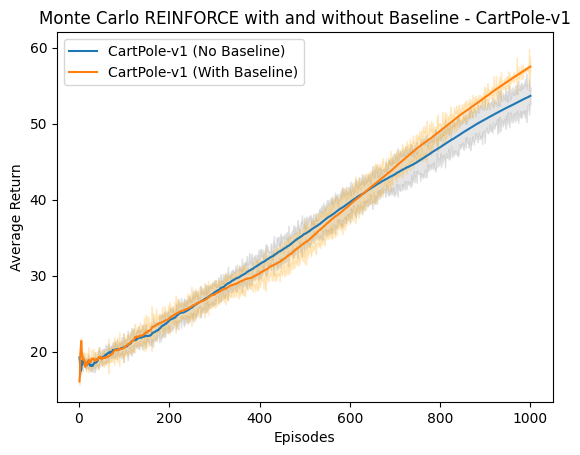

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define environments
env_name = 'CartPole-v1'
num_seeds = 5
max_episodes = 1000
lr = 0.001
max_steps=1000
updates=100

# Run experiments
env = gym.make(env_name)
returns_no_baseline = []
returns_with_baseline = []

for seed in range(num_seeds):
    torch.manual_seed(seed)
    env.seed(seed)
    policy_net_1 = nn.Sequential(
        nn.Linear(env.observation_space.shape[0], 64),
        nn.ReLU(),
        nn.Linear(64, env.action_space.n)
    )

    policy_net_2 = nn.Sequential(
        nn.Linear(env.observation_space.shape[0], 64),
        nn.ReLU(),
        nn.Linear(64, env.action_space.n)
    )

    agent_no_baseline = MonteCarloREINFORCE(env, policy_net_1, gamma=0.99, with_baseline=False)
    agent_with_baseline = MonteCarloREINFORCE(env, policy_net_2, gamma=0.99, with_baseline=True)



    score_with_no_baseline=agent_no_baseline.train(episodes=max_episodes, lr=lr, max_steps=max_steps, updates=updates,env_name=env_name)
    score_with_baseline=agent_with_baseline.train(episodes=max_episodes, lr=lr, max_steps=max_steps, updates=updates,env_name=env_name)

    returns_no_baseline.append(score_with_no_baseline)
    returns_with_baseline.append(score_with_baseline)

# Calculate average returns over seeds


avg_returns_no_baseline = np.mean(returns_no_baseline, axis=0)
avg_returns_with_baseline = np.mean(returns_with_baseline, axis=0)
std_scores_no_baseline = np.std(returns_no_baseline, axis=0)
std_scores_with_baseline = np.std(returns_with_baseline, axis=0)
# Taking moving average for both with baseline and without baseline
avg_returns_no_baseline = moving_average(avg_returns_no_baseline)
avg_returns_with_baseline = moving_average(avg_returns_with_baseline)

# Generate x-axis values (episode numbers)
episodes_1 = np.arange(1, len(avg_returns_no_baseline) + 1)


# Plot average returns
plt.plot(episodes_1, avg_returns_no_baseline, label=f'{env_name} (No Baseline)')
plt.fill_between(episodes_1, avg_returns_no_baseline - 0.1*std_scores_no_baseline, avg_returns_no_baseline +0.1* std_scores_no_baseline, color='gray', alpha=0.2)
plt.plot(episodes_1, avg_returns_with_baseline, label=f'{env_name} (With Baseline)')
plt.fill_between(episodes_1, avg_returns_with_baseline -0.1 * std_scores_with_baseline, avg_returns_with_baseline + 0.1*std_scores_with_baseline, color='orange', alpha=0.2)


# Add labels and legend for the current plot
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.title(f'Monte Carlo REINFORCE with and without Baseline - {env_name}')
plt.legend()
plt.show()


# Monte Carlo for Acrobot-v1

Episode 100: For Acrobot-v1  Without Baseline Average_Return:   -98.35 
Episode 200: For Acrobot-v1  Without Baseline Average_Return:   -98.35 
Episode 300: For Acrobot-v1  Without Baseline Average_Return:   -98.35 
Episode 400: For Acrobot-v1  Without Baseline Average_Return:   -98.35 
Episode 500: For Acrobot-v1  Without Baseline Average_Return:   -98.35 
Episode 100: For Acrobot-v1  With Baseline Average_Return:   -94.57 
Episode 200: For Acrobot-v1  With Baseline Average_Return:   -84.96 
Episode 300: For Acrobot-v1  With Baseline Average_Return:   -79.79 
Episode 400: For Acrobot-v1  With Baseline Average_Return:   -76.67 
Episode 500: For Acrobot-v1  With Baseline Average_Return:   -75.30 
Episode 100: For Acrobot-v1  Without Baseline Average_Return:   -98.35 
Episode 200: For Acrobot-v1  Without Baseline Average_Return:   -98.35 
Episode 300: For Acrobot-v1  Without Baseline Average_Return:   -98.35 
Episode 400: For Acrobot-v1  Without Baseline Average_Return:   -98.35 
Episode

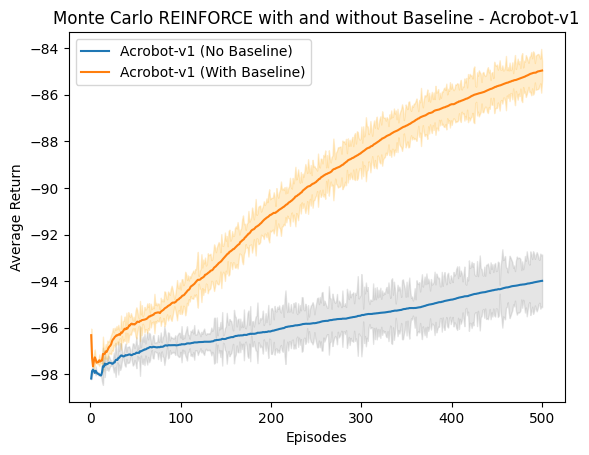

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define environments
env_name = 'Acrobot-v1'
num_seeds = 5
max_episodes = 500
lr =0.001
max_steps=1000
updates=100

# Run experiments

env = gym.make(env_name)
returns_no_baseline = []
returns_with_baseline = []

for seed in range(num_seeds):
    torch.manual_seed(seed)
    env.seed(seed)
    policy_net_1 = nn.Sequential(
        nn.Linear(env.observation_space.shape[0], 64),
        nn.ReLU(),
        nn.Linear(64, env.action_space.n)
    ).to(device)

    policy_net_2 = nn.Sequential(
        nn.Linear(env.observation_space.shape[0], 64),
        nn.ReLU(),
        nn.Linear(64, env.action_space.n)
    ).to(device)

    agent_no_baseline = MonteCarloREINFORCE(env, policy_net_1, gamma=0.99, with_baseline=False)
    agent_with_baseline = MonteCarloREINFORCE(env, policy_net_2, gamma=0.99, with_baseline=True)



    score_with_no_baseline=agent_no_baseline.train(episodes=max_episodes, lr=lr, max_steps=max_steps, updates=updates,env_name=env_name)
    score_with_baseline=agent_with_baseline.train(episodes=max_episodes, lr=lr, max_steps=max_steps, updates=updates,env_name=env_name)

    returns_no_baseline.append(score_with_no_baseline)
    returns_with_baseline.append(score_with_baseline)

# Calculate average returns over seeds
avg_returns_no_baseline = np.mean(returns_no_baseline, axis=0)
avg_returns_with_baseline = np.mean(returns_with_baseline, axis=0)
std_scores_no_baseline = np.std(returns_no_baseline, axis=0)
std_scores_with_baseline = np.std(returns_with_baseline, axis=0)
# Taking moving average for both with baseline and without baseline
avg_returns_no_baseline = moving_average(avg_returns_no_baseline)
avg_returns_with_baseline = moving_average(avg_returns_with_baseline)

# Generate x-axis values (episode numbers)
episodes_1 = np.arange(1, len(avg_returns_no_baseline) + 1)


# Plot average returns
plt.plot(episodes_1, avg_returns_no_baseline, label=f'{env_name} (No Baseline)')
plt.fill_between(episodes_1, avg_returns_no_baseline - 0.1*std_scores_no_baseline, avg_returns_no_baseline +0.1* std_scores_no_baseline, color='gray', alpha=0.2)
plt.plot(episodes_1, avg_returns_with_baseline, label=f'{env_name} (With Baseline)')
plt.fill_between(episodes_1, avg_returns_with_baseline -0.1 * std_scores_with_baseline, avg_returns_with_baseline + 0.1*std_scores_with_baseline, color='orange', alpha=0.2)


# Add labels and legend for the current plot
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.title(f'Monte Carlo REINFORCE with and without Baseline - {env_name}')
plt.legend()
plt.show()

